In [1]:
# import package

# model
import tensorflow as tf
from tensorflow import keras

# dataset and transformation
import io
import os
import cv2
import math
import glob
from sklearn.model_selection import train_test_split

# display images
import matplotlib.pyplot as plt 
%matplotlib inline

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

plt.rc('font', family='NanumBarunGothic')

# utils
import numpy as np
import pandas as pd
import time
import copy

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [2]:
# GPU check
!nvidia-smi

Mon Jun  6 04:09:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# dataset download

!unzip -qq /content/drive/MyDrive/dataset.zip -d ./dataset
!cp /content/drive/MyDrive/dataset.csv ./dataset.csv

In [4]:
dataset = glob.glob(os.path.join('./dataset', '*.jpg'))
print(len(dataset))

148355


In [5]:
df = pd.read_csv('./dataset.csv')
print(df.__len__())
df.head(5)

148355


,path,label
0,./dataset/0_aaayejpselwjixb.jpg,0
1,./dataset/0_aaayejpselwjixb_0_1391.jpg,0
2,./dataset/0_aaayejpselwjixb_0_2262.jpg,0
3,./dataset/0_aaayejpselwjixb_0_4355.jpg,0
4,./dataset/0_aabjlskkjdbxeac.jpg,0


In [6]:
xs = np.array(df['path'])
ys = np.array(df['label'])

train_x, valid_x, train_y, valid_y = train_test_split(xs, ys, test_size=0.2)
train_x, test_x, train_y, test_y = train_test_split(xs, ys, test_size=0.2)

train_x = np.array([cv2.imread(item, cv2.IMREAD_GRAYSCALE) / 255 for item in train_x]).reshape(train_x.shape[0], 96, 96, 1)
valid_x = np.array([cv2.imread(item, cv2.IMREAD_GRAYSCALE) / 255 for item in valid_x]).reshape(valid_x.shape[0], 96, 96, 1)
test_x = np.array([cv2.imread(item, cv2.IMREAD_GRAYSCALE) / 255 for item in test_x]).reshape(test_x.shape[0], 96, 96, 1)

train_y = tf.keras.utils.to_categorical(train_y, 5)
valid_y = tf.keras.utils.to_categorical(valid_y, 5)
test_y = tf.keras.utils.to_categorical(test_y, 5)

In [7]:
def show_sample(image, label, sample_count=25):
    grid_count = math.ceil(math.ceil(math.sqrt(sample_count)))
    grid_cout = min(grid_count, len(image), len(label))
    plt.figure(figsize=(2*grid_count, 2*grid_count))

    for i in range(sample_count):
        plt.subplot(grid_count, grid_count, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image[i].reshape(96, 96), cmap=plt.cm.gray)
        plt.xlabel(label[i], fontsize=14)
    plt.show()

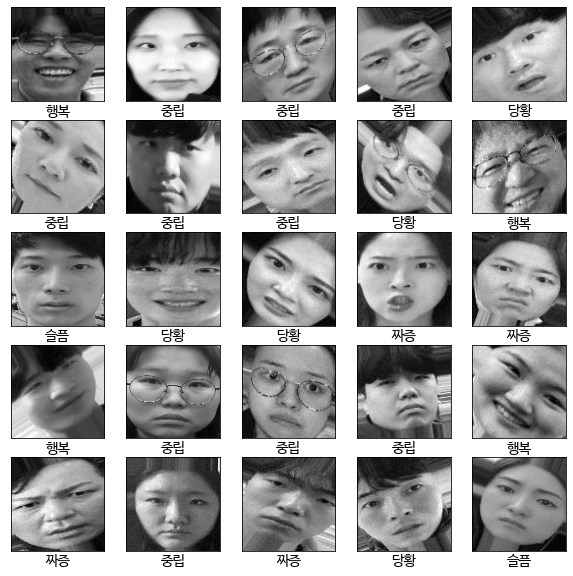

In [8]:
class_to_emotion = {
    '0': '짜증',
    '1': '당황',
    '2': '행복',
    '3': '중립',
    '4': '슬픔'
}

show_sample(train_x, [class_to_emotion[str(cls.argmax())] for cls in train_y])

In [12]:
def bottleneck_residual_block(X, filters, reduce=False, s=2):
    F1, F2, F3 = filters
    X_shortcut = X
    
    if reduce:
        X = keras.layers.Conv2D(filters=F1, kernel_size=(1,1), strides=(s,s), padding='valid', kernel_initializer=keras.initializers.glorot_uniform(seed=0))(X)
        X = keras.layers.BatchNormalization(axis=3)(X)
        X = keras.layers.ReLU()(X)
        
        X_shortcut = keras.layers.Conv2D(filters=F3, kernel_size=(1,1), strides=(s,s), padding='valid', kernel_initializer=keras.initializers.glorot_uniform(seed=0))(X_shortcut)
        X_shortcut = keras.layers.BatchNormalization(axis=3)(X_shortcut)
    else: 
        X = keras.layers.Conv2D(filters=F1, kernel_size=(1,1), strides=(1,1), padding='valid', kernel_initializer=keras.initializers.glorot_uniform(seed=0))(X)
        X = keras.layers.BatchNormalization(axis=3)(X)
        X = keras.layers.ReLU()(X)
    
    X = keras.layers.Conv2D(filters=F2, kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer=keras.initializers.glorot_uniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3)(X)
    X = keras.layers.ReLU()(X)

    X = keras.layers.Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding='valid', kernel_initializer=keras.initializers.glorot_uniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3)(X)

    X = keras.layers.Add()([X, X_shortcut])
    X = keras.layers.ReLU()(X)
    
    return X

def ResNet50(classes):
    X_input = keras.layers.Input(shape=[96, 96, 1])

    X = keras.layers.Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer=keras.initializers.glorot_uniform(seed=0))(X_input)
    X = keras.layers.BatchNormalization(axis=3)(X)
    X = keras.layers.ReLU()(X)
    X = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = bottleneck_residual_block(X, [64, 64, 256], reduce=True, s=1)
    X = bottleneck_residual_block(X, [64, 64, 256])
    X = bottleneck_residual_block(X, [64, 64, 256])

    X = bottleneck_residual_block(X, [128, 128, 512], reduce=True)
    X = bottleneck_residual_block(X, [128, 128, 512])
    X = bottleneck_residual_block(X, [128, 128, 512])
    X = bottleneck_residual_block(X, [128, 128, 512])

    X = bottleneck_residual_block(X, [256, 256, 1024], reduce=True)
    X = bottleneck_residual_block(X, [256, 256, 1024])
    X = bottleneck_residual_block(X, [256, 256, 1024])
    X = bottleneck_residual_block(X, [256, 256, 1024])
    X = bottleneck_residual_block(X, [256, 256, 1024])
    X = bottleneck_residual_block(X, [256, 256, 1024])

    X = bottleneck_residual_block(X, [512, 512, 2048], reduce=True)
    X = bottleneck_residual_block(X, [512, 512, 2048])
    X = bottleneck_residual_block(X, [512, 512, 2048])

    X = keras.layers.AveragePooling2D((1,1))(X)

    X = keras.layers.Flatten()(X)
    X = keras.layers.Dense(units=512, activation='relu')(X)
    X = keras.layers.Dense(units=classes, activation='softmax')(X)
    
    model = keras.models.Model(inputs=X_input, outputs=X)

    return model

In [13]:
model = ResNet50(5)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 conv2d_53 (Conv2D)             (None, 45, 45, 64)   3200        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_53 (BatchN  (None, 45, 45, 64)  256         ['conv2d_53[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_49 (ReLU)                (None, 45, 45, 64)   0           ['batch_normalization_53[0]

In [14]:
start_time = time.time()

callbacks = tf.keras.callbacks.ModelCheckpoint(filepath='model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    train_x, train_y, validation_data=(valid_x, valid_y),
    epochs=50, batch_size=16, callbacks=[callbacks]
)

print(f'{time.time() - start_time}초 동안 학습함.')

Epoch 1/50
7418/7418 [==============================] - 489s 64ms/step - loss: 1.3229 - accuracy: 0.4605 - val_loss: 1.2615 - val_accuracy: 0.4672
Epoch 2/50
7418/7418 [==============================] - 465s 63ms/step - loss: 0.9700 - accuracy: 0.6202 - val_loss: 1.5531 - val_accuracy: 0.5116
Epoch 3/50
7418/7418 [==============================] - 465s 63ms/step - loss: 0.7055 - accuracy: 0.7447 - val_loss: 0.6459 - val_accuracy: 0.7676
Epoch 4/50
7418/7418 [==============================] - 462s 62ms/step - loss: 0.5997 - accuracy: 0.7881 - val_loss: 1.0938 - val_accuracy: 0.5938
Epoch 5/50
7418/7418 [==============================] - 463s 62ms/step - loss: 0.5370 - accuracy: 0.8132 - val_loss: 0.6149 - val_accuracy: 0.7780
Epoch 6/50
7418/7418 [==============================] - 462s 62ms/step - loss: 0.4860 - accuracy: 0.8312 - val_loss: 0.5229 - val_accuracy: 0.8146
Epoch 7/50
7418/7418 [==============================] - 461s 62ms/step - loss: 0.4416 - accuracy: 0.8468 - val_loss: 0

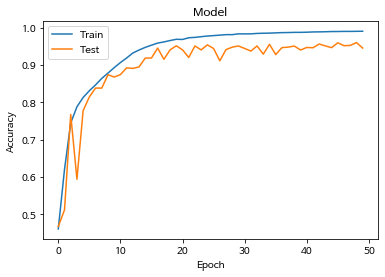

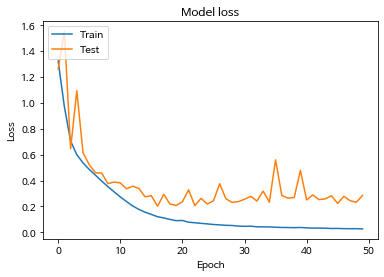

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [18]:
model = keras.models.load_model('model.h5')
pred = model.predict(test_x)

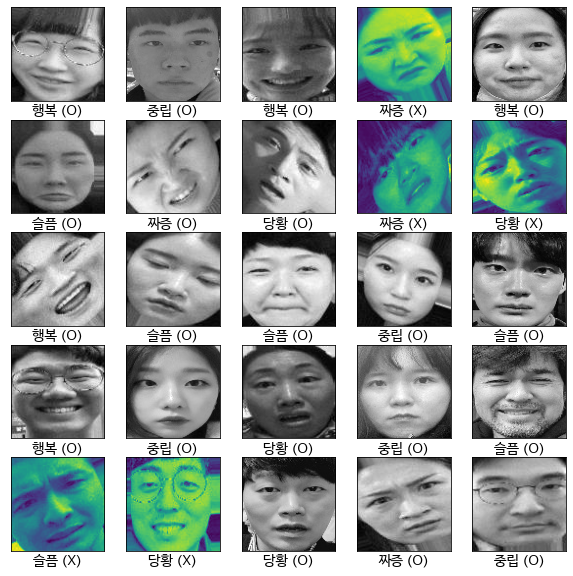

In [28]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    is_correct = 'O' if np.argmax(pred[i]) == np.argmax(test_y[i]) else 'X'
    plt.imshow(test_x.reshape(-1, 96, 96)[i], cmap=plt.cm.gray if np.argmax(pred[i]) == np.argmax(test_y[i]) else None)
    plt.xlabel(f'{class_to_emotion[str(np.argmax(pred[i]))]} ({is_correct})', fontsize=14)
plt.show()